# 聚类分析

餐饮企业经常会碰到这样的问题：
1. 如何通过对餐饮客户消费行为的测量，进一步评判餐饮客户的价值和对餐饮客户进行细分，找到有价值的客户群和需关注的客户群？
2. 如何合理对菜品进行分析，以便区分哪些菜品畅销毛利又高，哪些菜品滞销毛利又低？

餐饮企业遇到的这些问题，可以通过聚类分析解决。


## 1. 常用聚类分析算法
与分类不同，聚类分析是在没有给定划分类别的情况下，根据数据相似度进行样本分组的一种方法。与分类模型需要使用有类标记样本构成的训练数据不同，聚类分析可以建立在无类标记的数据上，是一种非监督的学习算法。

聚类的输入是一组未被标记的样本，聚类根据数据自身的距离或相似度将其划分为若干组，划分的原则是组内距离最小化而组间（外部）距离最大化。

1. 基于距离的聚类方法：可以选择不同的距离计算方法来寻找样本与中心点之间的距离，常用算法有K-Means算法
2. 层次聚类方法：通过计算样本之间的相似度或距离，逐层进行归纳的方法，常用算法有BIRCH算法（平衡迭代规约和聚类）
3. 基于密度的方法：寻找不同的集合，使得集合的密度最大。常用算法有DBSCAN算法
4. 谱聚类：通过计算样本之间的相似度构建相似度矩阵，然后通过计算特征向量来实现对相似度矩阵的切分，具有速度快，无需指定Cluster数量的优点。
5. 基于模型的方法：统计学方法、神经网络方法。聚类方法可以理解成特殊的编码或者压缩，它能够将一个多维数据压缩成一个数字，同时解压或者解码之后，信息损失最小。

## 2. 常用的相似度度量方法

### 2.1 基于距离的相似度度量方法
1. 欧几里得距离：d(x,y) = sqrt((x1-y1)^2 + (x2-y2)^2 + ... + (xn-yn)^2)
2. 曼哈顿距离：d(x,y) = abs(x1-y1) + abs(x2-y2) + ... + abs(xn-yn)
3. 闵可夫斯基距离，与欧几里得距离类似



### 2.2 余弦夹角距离
对于文档数据，需要进行数值化的转换，同时文档之间长度不同，所以是无法直接计算文档之间的距离。所以计算文档的相似度，通常需要进行文档-词向量转换，然后通过余弦夹角计算文档相似度。

文档-词向量可以表示成：D = TF x IDF
 * TF是文档中每个词的出现频率
 * IDF是文档中每个词在文档集中出现频率的倒数
 
两个文档之间的相似度的计算公式为：sim(d1, d2) = cos(d1, d2)



## 3. 餐饮客户消费行为分析
通过分析餐饮客户的消费行为数据，根据这些数据可以将客户分类成不同客户群，并评价这些客户群的价值。

### 3.1 对客户进行分组
首先按照客户的消费频率、总金额和最后一次消费时间间隔，对客户进行分组。

In [1]:
import pandas as pd

input_file = '../data/consumption_data.xls'

data = pd.read_excel(input_file, index_col = 'Id')
data.head()

,R,F,M
Id,,,
1,27,6,232.61
2,3,5,1507.11
3,4,16,817.62
4,3,11,232.81
5,14,7,1913.05


数据结构：
* ID：客户ID
* R：最近一次消费时间间隔
* F：消费频率
* M：消费总金额

通过K-Means将客户进行分类，业务专家可以根据分类的结果进行分析，最终对不同分组的用户进行描述。

In [2]:
k = 3
iteration = 500 # 聚类最大的循环次数

normalized_data = 1.0 * (data - data.mean()) / data.std() # 数据标准化

from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, n_jobs = 1, max_iter = iteration, random_state = 0)
model.fit(normalized_data) # 开始聚类

r1 = pd.Series(model.labels_).value_counts() # 统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_) # 找出聚类中心

# 横向连接（0是纵向），得到聚类中心对应的类别下的数目
r = pd.concat([r2, r1], axis = 1)
r.columns = list(data.columns) + [u'类别数目']
print(u'计算得到的各类中心点和类别数目')
print(r)

计算得到的各类中心点和类别数目
          R         F         M  类别数目
0 -0.160451  1.114802  0.392844   341
1  3.455055 -0.295654  0.449123    40
2 -0.149353 -0.658893 -0.271780   559


In [3]:
# 详细输出原始数据及其类别
from os import makedirs

output_file = './tmp/data_type.xls'
makedirs('./tmp', exist_ok=True)

r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)
r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
r.to_excel(output_file)
r.head()

,R,F,M,聚类类别
Id,,,,
1,27,6,232.61,2
2,3,5,1507.11,2
3,4,16,817.62,0
4,3,11,232.81,2
5,14,7,1913.05,2


### 3.2 按分组对客户进行分析
对客户进行分组之后，可以同一组的客户中，从不同特征的角度来分析客户的分布。然后对分组进行解读。


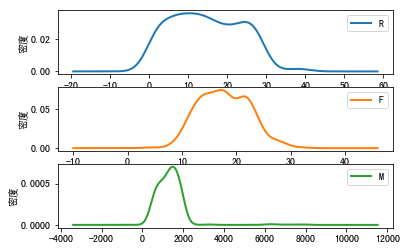

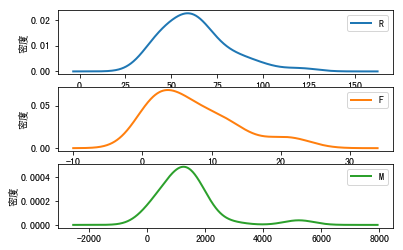

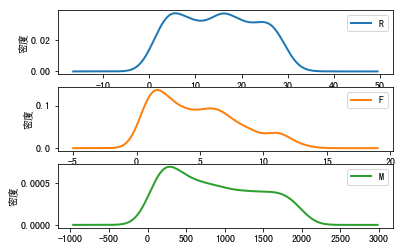

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

def density_plot(data): #自定义作图函数
    p = data.plot(kind='kde', linewidth = 2, subplots = True, sharex = False)
    [p[i].set_ylabel(u'密度') for i in range(k)]
    plt.legend()
    return plt

for i in range(k):
  density_plot(data[r[u'聚类类别']==i])

plt.show()

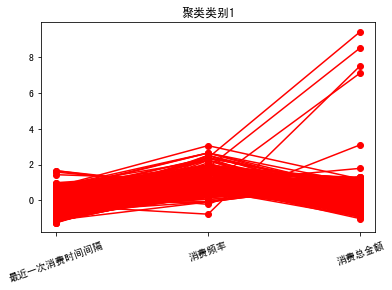

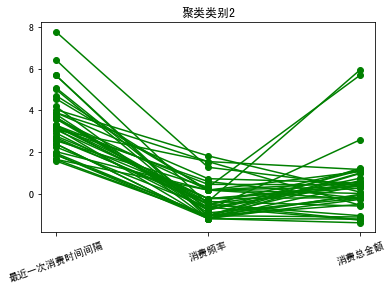

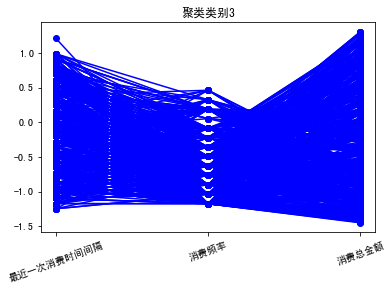

In [5]:
style = ['ro-', 'go-', 'bo-']
xlabels = [u'最近一次消费时间间隔', u'消费频率', u'消费总金额']
pic_output = './tmp/type_' #聚类图文件名前缀

for i in range(k): #逐一作图，作出不同样式
    plt.figure()
    tmp = normalized_data[r[u'聚类类别'] == i].iloc[:,:3] #提取每一类
    for j in range(len(tmp)):
        plt.plot(range(1, 4), tmp.iloc[j], style[i])
        plt.xticks(range(1, 4), xlabels, rotation = 20) #坐标标签
        plt.title(u'聚类类别%s' %(i+1)) #我们计数习惯从1开始
        plt.subplots_adjust(bottom=0.15) #调整底部
    plt.show()



#### 分组1特点
R（最近一次消费时间间隔）间隔相对较小，主要集中在0～30天；消费次数集中在10～25次；消费金额在500～2000。

#### 分组2特点
R间隔相对较大，主要集中在30～80天；消费次数集中在0～25次；消费金额在0～2000。

#### 分组3特点
R间隔相对较大，主要集中在0～30天；消费次数集中在0～12次；消费金额在0～1800。

#### 对比分析
分群1时间间隔较短，消费次数多，而且消费金额较大，是高消费、高价值人群。分群3的时间间隔、消费次数和消费金额处于中等水平，代表着一般客户。分群2的时间间隔较长，消费次数较少，消费金额也不是特别高，是价值较低的客户群体。

## 4. 聚类结果可视化

### 4.1. TSNE
TSNE是Laurens Van Der Maaten和Geoffrey Hintton在2008年提出的，它的定位是高维数据的可视化。人们总喜欢能够直观地展示研究结果，聚类也不例外。然而，通常来说输入的特征数是高维的（大于3维），一般难以直接以原特征对聚类结果进行展示。而TSNE提高了一种有效的数据降维方式，让我们可以在2维或者3维的空间中展示聚类结果。

下面用TSNE对上述K-Means聚类的结果以二维的方式展示出来。

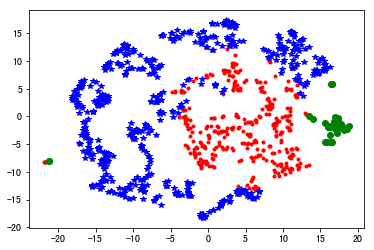

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE()
reduced_data = tsne.fit_transform(normalized_data) # 进行数据降维
transformed_data = pd.DataFrame(reduced_data, index = normalized_data.index) # 转换数据格式

d = transformed_data[r[u'聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = transformed_data[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = transformed_data[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.show()

### 4.2. PCA主成分法

也可以通过主成分分析法对聚类结果进行降维

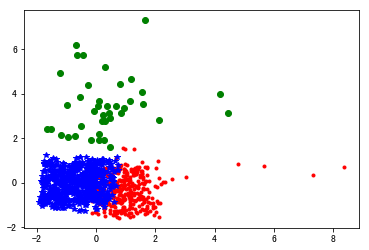

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data) # 进行数据降维
transformed_data = pd.DataFrame(reduced_data, index = normalized_data.index) # 转换数据格式

d = transformed_data[r[u'聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = transformed_data[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = transformed_data[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.show()

## 作业

1. 通过分析某城市内各个基站的：工作日上班时间人均停留时间、凌晨人均停留时间、周末人均停留时间、日均人流量，来对基站进行聚类分析。（数据文件为：../data/business_circle.xls）